In [1]:
#encoding="utf-8"
import pandas as pd
import numpy as np
import time
import requests
import json

In [2]:
# 获取火币或者T8或者币安历史合约K线收盘价数据
def get_future_klinedata0(platform, symbol, granularity=200):
    if platform == 'huobi':
        for _ in range(3):
            now = int(time.time())
            start_time = now - 86400 * granularity
            contract_code = "{}-usdt".format(symbol).upper()
            url = huobifuture_api_url + '/linear-swap-ex/market/history/kline?contract_code={}&period=1day&from={}&to={}'.format(
                contract_code, start_time, now)
            try:
                res = requests.get(url)
                if res.status_code ==200:
                    resdict = json.loads(res.content.decode())
                    df = pd.DataFrame()
                    df['close'] = [i['close'] for i in resdict['data']]
                    break
            except Exception as e:
                print(e)
                df = pd.DataFrame()
        return df

In [3]:
#获取多个币种永续合约的30日收盘价
def get_contracts_klinedata(platform, symbols):
    contracts_klinedata = None
    for symbol in symbols:
        df = get_future_klinedata0(platform, symbol)
        df.rename(columns={'close': symbol}, inplace=True)
        contracts_klinedata = df if contracts_klinedata is None else pd.concat([contracts_klinedata, df], axis=1)
    return contracts_klinedata

In [4]:
huobifuture_api_url='https://api.btcgateway.pro'
symbols = ['btc','eth','link','eos','fil','ltc','dot','doge']
df=get_contracts_klinedata("huobi",symbols)

In [5]:
df

,btc,eth,link,eos,fil,ltc,dot,doge
0,36595.7,1582.51,23.5938,3.0286,22.854,143.97,19.7598,0.046662
1,37989.0,1742.18,26.4888,3.1741,24.033,155.61,21.0000,0.045982
2,40847.5,1677.07,25.1361,3.1779,24.740,162.16,20.0479,0.050547
3,38000.5,1540.85,23.8702,3.3175,24.008,148.50,19.2052,0.063687
4,43754.6,1739.77,25.4242,3.5206,24.623,164.69,22.5622,0.081315
...,...,...,...,...,...,...,...,...
196,45776.9,3067.67,26.2794,5.0282,68.358,170.84,25.7911,0.307548
197,48732.7,3284.99,28.4346,5.4121,73.063,182.82,28.0304,0.330473
198,49193.0,3272.00,28.4778,5.4423,73.957,181.96,28.5693,0.322505
199,48524.6,3180.89,27.3805,5.2893,76.265,182.33,27.1340,0.311583


In [6]:
#复合动量因子
def compound_momentum(symbols,df):
    judge_list=None
    for symbol in symbols:
        df['return']=df[symbol].pct_change().dropna()
        up_days=np.sum(df['return'].values>0)
        down_days=np.sum(df['return'].values<0)
        return_all=df['return'].sum()
        judge=pd.DataFrame({symbol:[up_days/(up_days+down_days)*return_all]})
        #judge=pd.DataFrame({symbol:[1*return_all]})
        judge_list =judge.T if judge_list is None else pd.concat([judge_list,judge.T],axis=0)
    judge_list.columns=['return']
    judge_list.sort_values(by=['return'], ascending=True, inplace=True)
    return judge_list

In [7]:
#收益率偏度因子
def skew_factor(symbols,df):
    skew_list=None
    for symbol in symbols:
        #df=get_future_klinedata0("T8ex",symbol)
        ret=np.log(df[symbol]/df[symbol].shift())
        ret.columns=[symbol]
        ret_skew=pd.DataFrame({symbol:[ret.skew()]}) #计算偏度后转置，index为【future】,即期货种类代码
        skew_list=ret_skew.T if skew_list is None else pd.concat([skew_list,ret_skew.T],axis=0)
    skew_list.columns=['skew']
    skew_list.sort_values(by=['skew'],ascending=False,inplace=True)
    return skew_list

In [8]:
def weighted_factor_score(factor, factor_name, weight):
    #给定每只期货合约的因子数据及权重，返回加权后的打分结果
    # weight是因子的权重，是该因子多空组合夏普比率，计算过程省了
    factor.columns = [factor_name]
    factor.iloc[:2]=1
    factor.iloc[2:-2]=0
    factor.iloc[-2:]=-1
    factor = factor*weight 
    return factor

In [9]:
result_list=None
for i in range(151):
    #factor_momentum = weighted_factor_score(basic_momentum(symbols,df.iloc[i+1:50+i+1],df_index.iloc[i+1:50+i+1]), '基差动量',0)    #调仓频繁
    judge_list = weighted_factor_score(compound_momentum(symbols,df.iloc[i+1:50+i+1]), '复合动量',1) #周调仓
    skew_list = weighted_factor_score(skew_factor(symbols,df.iloc[i+1:50+i+1]), '偏度',1)  #周调仓
    #ware_house = weighted_factor_score(ware_house_factor(symbols,positions.iloc[i+1:i+10+1]), '仓单因子', 0)
    #factor_pure_long = weighted_factor_score(pure_long_factor(symbols,pure_long_position.iloc[i+1:i+20+1]), '净多头变化率', 1)
    #result = pd.concat([factor_momentum, judge_list, skew_list], axis=1)
    result=pd.concat([judge_list,skew_list],axis=1)
    result = result.sum(axis=1).sort_values(ascending=False)
    result.iloc[:2] = 1
    result.iloc[2:-2] = 0
    result.iloc[-2:] = -1
    result_list = result if result_list is None else pd.concat([result_list,result], axis=1)

<ipython-input-6-b15378bdea3b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['return']=df[symbol].pct_change().dropna()


In [10]:
result_list

,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doge,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
link,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
eth,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
fil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
btc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
dot,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
eos,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
ltc,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
result=result_list.T.reset_index(drop=True)
df['btc_pct']=np.log(df['btc']/df['btc'].shift())
df['eth_pct']=np.log(df['eth']/df['eth'].shift())
df['link_pct']=np.log(df['link']/df['link'].shift())
df['eos_pct']=np.log(df['eos']/df['eos'].shift())
df['fil_pct']=np.log(df['fil']/df['fil'].shift())
df['ltc_pct']=np.log(df['ltc']/df['ltc'].shift())
#df['uni_pct']=df['uni']/df['uni'].shift()
df['dot_pct']=np.log(df['dot']/df['dot'].shift())
df['doge_pct']=np.log(df['doge']/df['doge'].shift())

In [12]:
df_2=df[['btc_pct','eth_pct','link_pct','eos_pct','fil_pct','ltc_pct','dot_pct','doge_pct']]
df_3=df_2.iloc[50:].reset_index(drop=True)

In [13]:
df_3

,btc_pct,eth_pct,link_pct,eos_pct,fil_pct,ltc_pct,dot_pct,doge_pct
0,0.043902,0.027875,0.032365,0.120778,0.195053,0.052232,0.076376,0.054877
1,0.030255,0.025784,0.007406,-0.010694,0.176224,0.005982,0.010175,0.029010
2,0.025431,0.015193,0.024716,0.018115,-0.047470,0.023416,0.013779,-0.007063
3,0.024023,0.045545,0.021093,0.017816,0.012510,0.045146,0.051645,-0.002329
4,0.015124,0.022165,0.011175,0.018903,0.140434,0.011638,-0.008704,0.003435
...,...,...,...,...,...,...,...,...
146,-0.000841,-0.013701,-0.021533,-0.011744,-0.007026,-0.016717,0.038255,-0.035723
147,0.062571,0.068445,0.078821,0.073575,0.066563,0.067775,0.083260,0.071894
148,0.009401,-0.003962,0.001518,0.005565,0.012162,-0.004715,0.019043,-0.024406
149,-0.013680,-0.028240,-0.039294,-0.028516,0.030730,0.002031,-0.051545,-0.034453


In [14]:
df_1=pd.concat([df_3,result],axis=1)
df_1['btc_return']=df_1['btc_pct']*df_1['btc'].shift()
df_1['eth_return']=df_1['eth_pct']*df_1['eth'].shift()
df_1['link_return']=df_1['link_pct']*df_1['link'].shift()
df_1['eos_return']=df_1['eos_pct']*df_1['eos'].shift()
df_1['fil_return']=df_1['fil_pct']*df_1['fil'].shift()
df_1['ltc_return']=df_1['ltc_pct']*df_1['ltc'].shift()
#df_1['uni_return']=df_1['uni_pct']*df_1['uni'].shift()
df_1['dot_return']=df_1['dot_pct']*df_1['dot'].shift()
df_1['doge_return']=df_1['doge_pct']*df_1['doge'].shift()

In [15]:
df_4=df_1[['btc_return','eth_return','link_return','eos_return','fil_return','ltc_return','dot_return','doge_return',]]
df_4['return']=df_4.sum(axis=1)

<ipython-input-15-40dc90a6c329>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4['return']=df_4.sum(axis=1)


<AxesSubplot:>

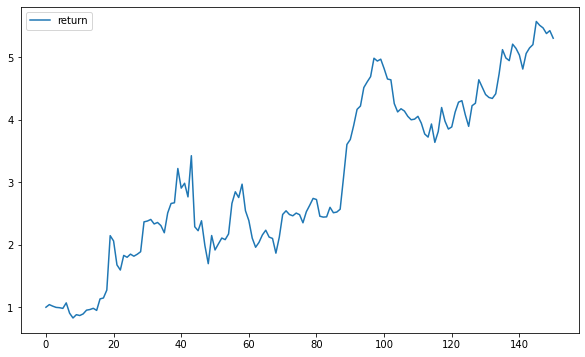

In [16]:
df_4[['return']].cumsum().apply(np.exp).plot(figsize=(10,6))

In [17]:
#仓单因子
#获取永续合约持仓
def future_position(platform,symbol):
    if platform=="binance":
        url='https://dapi.binance.com/futures/data/openInterestHist'
        #now = int(time.time())-86400 *29
        data={'symbol':symbol,'period':'1d',"pair":"{}USD".format(symbol)}
        df=pd.DataFrame()
        for _ in range(3):
            try:
                response=requests.get(url,params=data)
                if response.status_code==200:
                    res=response.json()
                    df[symbol]=[float(i['sumOpenInterest']) for i in res]
                    #df['time']=[time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(i["timestamp"]/1000)) for i in res]
                    break
            except Exception as e:
                print(e)
        return df 
    elif platform=="huobi":
        url='https://api.btcgateway.pro/linear-swap-api/v1/swap_his_open_interest'
        data={'contract_code':'{}-usdt'.format(symbol).upper(),'period':'1day',"amount_type":1}
        df=pd.DataFrame()
        for _ in range(3):
            try:
                response=requests.get(url,params=data)
                if response.status_code==200:
                    res=response.json()['data']['tick']
                    df[symbol]=[float(i['value']) for i in res]
                    break
            except Exception as e:
                print(e)
        return df

In [24]:
def ware_house_factor(symbols,df):
    ware_house_list=None
    for symbol in symbols:
        ware_house_pct=pd.DataFrame({symbol:[(float(df[symbol].iloc[-1])-float(df[symbol].iloc[0]))/float(df[symbol].iloc[0])]})
        ware_house_list =ware_house_pct.T if ware_house_list is None else pd.concat([ware_house_list,ware_house_pct.T],axis=0)
    ware_house_list.columns=['position_change']
    print(ware_house_list)
    ware_house_list.sort_values(by=['position_change'],ascending=False,inplace=True)
    ware_house_list.dropna(inplace=True)
    return ware_house_list

In [27]:
#获得多个币种近30日的持仓详情
def get_all_position(symbols):
    all_position=None
    for symbol in symbols:
        df=future_position("huobi",symbol)
        all_position=df if all_position is None else pd.concat([all_position,df],axis=1)
    return all_position

In [28]:
positions=get_all_position(symbols)

In [30]:
result_list=None
for i in range(38):
    #factor_momentum = weighted_factor_score(basic_momentum(symbols,df.iloc[i+1:50+i+1],df_index.iloc[i+1:50+i+1]), '基差动量',0)    #调仓频繁
    #judge_list = weighted_factor_score(compound_momentum(symbols,df.iloc[i+1:50+i+1]), '复合动量',0) #周调仓
    #skew_list = weighted_factor_score(skew_factor(symbols,df.iloc[i+1:50+i+1]), '偏度',0)  #周调仓
    ware_house = weighted_factor_score(ware_house_factor(symbols,positions.iloc[i+1:i+10+1]), '仓单因子', 1)
    #factor_pure_long = weighted_factor_score(pure_long_factor(symbols,pure_long_position.iloc[i+1:i+20+1]), '净多头变化率', 1)
    #result = pd.concat([factor_momentum, judge_list, skew_list], axis=1)
    result=pd.concat([ware_house],axis=1)
    result = result.sum(axis=1).sort_values(ascending=False)
    result.iloc[:2] = 1
    result.iloc[2:-2] = 0
    result.iloc[-2:] = -1
    result_list = result if result_list is None else pd.concat([result_list,result], axis=1)

      position_change
btc          0.102793
eth          0.062430
link         0.053186
eos          0.067552
fil         -0.046472
ltc          0.109798
dot          0.065708
doge         0.103194
      position_change
btc          0.147440
eth          0.120573
link         0.288999
eos          0.212773
fil         -0.023109
ltc          0.281661
dot         -0.077121
doge         0.270613
      position_change
btc          0.215381
eth          0.071783
link         0.253353
eos          0.132704
fil          0.006898
ltc          0.332890
dot          0.039871
doge         0.120564
      position_change
btc          0.100125
eth          0.120645
link         0.338933
eos          0.142700
fil          0.026293
ltc          0.298489
dot         -0.022199
doge         0.075430
      position_change
btc         -0.016737
eth          0.077147
link         0.175166
eos          0.072284
fil          0.010139
ltc          0.192848
dot         -0.027826
doge         0.102035
      posi

In [40]:
result=result_list.T.reset_index(drop=True)

In [41]:
df_2=df[['btc_pct','eth_pct','link_pct','eos_pct','fil_pct','ltc_pct','dot_pct','doge_pct']]
df_3=df_2.iloc[163:].reset_index(drop=True)

In [42]:
df_1=pd.concat([df_3,result],axis=1)
df_1
# df_1['btc_return']=df_1['btc_pct']*df_1['btc'].shift()
# df_1['eth_return']=df_1['eth_pct']*df_1['eth'].shift()
# df_1['link_return']=df_1['link_pct']*df_1['link'].shift()
# df_1['eos_return']=df_1['eos_pct']*df_1['eos'].shift()
# df_1['fil_return']=df_1['fil_pct']*df_1['fil'].shift()
# df_1['ltc_return']=df_1['ltc_pct']*df_1['ltc'].shift()
# #df_1['uni_return']=df_1['uni_pct']*df_1['uni'].shift()
# df_1['dot_return']=df_1['dot_pct']*df_1['dot'].shift()
# df_1['doge_return']=df_1['doge_pct']*df_1['doge'].shift()

,btc_pct,eth_pct,link_pct,eos_pct,fil_pct,ltc_pct,dot_pct,doge_pct,doge,ltc,eth,dot,eos,btc,fil,link
0,-0.011575,-0.025070,-0.035237,-0.020126,-0.032694,-0.039317,-0.060301,-0.050104,1.0,1.0,0.0,0.0,0.0,0.0,-1.0,-1.0
1,-0.012214,0.001796,-0.008847,-0.011257,0.008095,-0.017662,0.019490,0.056522,0.0,1.0,0.0,-1.0,0.0,0.0,-1.0,1.0
2,-0.021816,-0.037381,-0.041955,-0.047445,-0.006016,-0.043619,-0.074733,-0.056383,0.0,1.0,0.0,-1.0,0.0,0.0,-1.0,1.0
3,-0.026565,-0.007674,-0.035463,-0.043833,-0.073422,-0.036558,-0.043478,-0.028065,0.0,1.0,0.0,-1.0,0.0,0.0,-1.0,1.0
4,0.065546,0.078553,0.085744,0.059795,0.097144,0.072083,0.123585,0.179597,0.0,1.0,0.0,-1.0,0.0,-1.0,0.0,1.0
5,0.018030,0.039765,0.035840,0.017513,-0.019816,0.037195,0.038937,-0.037683,0.0,1.0,1.0,0.0,0.0,-1.0,-1.0,0.0
6,-0.005378,0.007050,-0.018060,-0.012857,-0.005284,-0.022926,-0.023491,-0.026907,-1.0,0.0,1.0,1.0,0.0,0.0,-1.0,0.0
7,0.046580,0.048642,0.059308,0.042628,0.094181,0.055442,0.066810,0.033268,-1.0,0.0,1.0,1.0,0.0,0.0,-1.0,0.0
8,0.009168,-0.005656,-0.009520,-0.022650,-0.055573,-0.003036,-0.015883,-0.003121,-1.0,0.0,1.0,0.0,0.0,0.0,-1.0,1.0
9,0.120971,0.091099,0.169999,0.084678,0.100610,0.096357,0.102813,0.120337,-1.0,0.0,0.0,1.0,0.0,0.0,-1.0,1.0


In [43]:
df_1['btc_return']=df_1['btc_pct']*df_1['btc'].shift()
df_1['eth_return']=df_1['eth_pct']*df_1['eth'].shift()
df_1['link_return']=df_1['link_pct']*df_1['link'].shift()
df_1['eos_return']=df_1['eos_pct']*df_1['eos'].shift()
df_1['fil_return']=df_1['fil_pct']*df_1['fil'].shift()
df_1['ltc_return']=df_1['ltc_pct']*df_1['ltc'].shift()
#df_1['uni_return']=df_1['uni_pct']*df_1['uni'].shift()
df_1['dot_return']=df_1['dot_pct']*df_1['dot'].shift()
df_1['doge_return']=df_1['doge_pct']*df_1['doge'].shift()

<ipython-input-44-930f84d2016a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4['return']=df_4.sum(axis=1)


<AxesSubplot:>

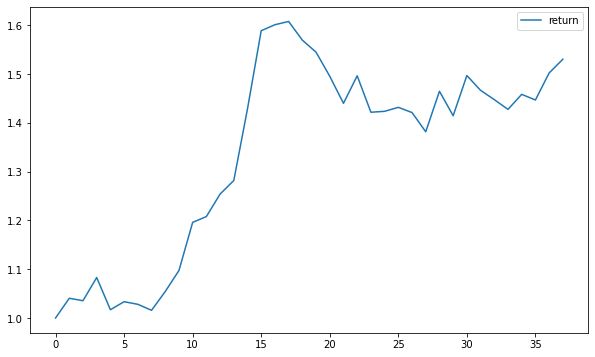

In [44]:
df_4=df_1[['btc_return','eth_return','link_return','eos_return','fil_return','ltc_return','dot_return','doge_return',]]
df_4['return']=df_4.sum(axis=1)
df_4[['return']].cumsum().apply(np.exp).plot(figsize=(10,6))